<a href="https://colab.research.google.com/github/JacoDuToit11/reasoning-mech-interp/blob/main/src/ReasoningInterp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"

if IN_COLAB:
    # Install packages
    %pip install transformer_lens
    %pip install einops
    %pip install jaxtyping
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists(f"/content/{chapter}"):
        !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
        !unzip /content/main.zip 'ARENA_3.0-main/chapter1_transformer_interp/exercises/*'
        sys.path.append(f"/content/{repo}-main/{chapter}/exercises")
        os.remove("/content/main.zip")
        os.rename(f"{repo}-main/{chapter}", chapter)
        os.rmdir(f"{repo}-main")
        os.chdir(f"{chapter}/exercises")
else:
    raise Exception("If running from VSCode, you should copy code from the Streamlit page, not the Colab.")

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-ivbysb_y
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-ivbysb_y
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [19]:
import sys
from pathlib import Path
import torch as t
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import plotly.express as px
import re
import itertools
from jaxtyping import Float, Int, Bool
from typing import Literal, Callable
from functools import partial
from IPython.display import display, HTML
from rich.table import Table, Column
from rich import print as rprint
import circuitsvis as cv
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

# Make sure exercises are in the path
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part41_indirect_object_identification").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, scatter, bar

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

MAIN = __name__ == "__main__"

In [20]:
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")

gpt2_text = 'I open my umbrella because it is raining'

gpt2_tokens = gpt2_small.to_tokens(gpt2_text)
gpt2_logits, gpt2_cache = gpt2_small.run_with_cache(gpt2_tokens, remove_batch_dim=True)

print(type(gpt2_cache))
attention_pattern = gpt2_cache["pattern", 0]
print(attention_pattern.shape)
gpt2_str_tokens = gpt2_small.to_str_tokens(gpt2_text)

print("Layer 0 Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=gpt2_str_tokens,
    attention=attention_pattern,
    attention_head_names=[f"L0H{i}" for i in range(12)],
))

Loaded pretrained model gpt2-small into HookedTransformer
<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 9, 9])
Layer 0 Head Attention Patterns:


In [ ]:
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")

# A->B ("so") attention results

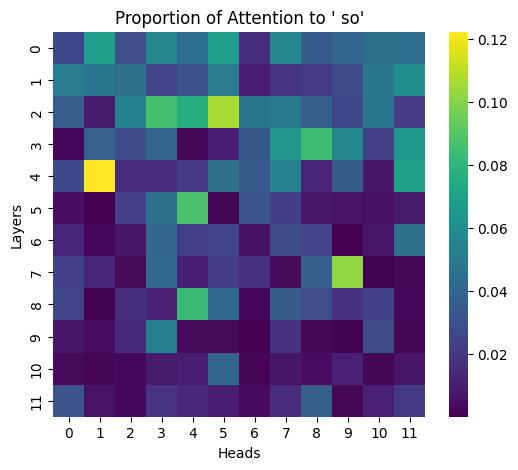

In [27]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Define an array of prompts
prompts = ['Bob and Chris got work to do so they are eager to explore.', 'Bob and Chris made a cake so they are excited and happy.']

causal_delim = " so"
n_layers = gpt2_small.cfg.n_layers
n_heads = gpt2_small.cfg.n_heads

# Will accumulate the proportions layer-by-layer, head-by-head
attn_prop_causal_delim_all_prompts = torch.zeros(n_layers, n_heads)

for prompt in prompts:
    tokens = gpt2_small.to_tokens(prompt)
    logits, cache = gpt2_small.run_with_cache(tokens, remove_batch_dim=True)

    str_tokens = gpt2_small.to_str_tokens(prompt)
    if causal_delim not in str_tokens:
        continue

    delim_idx = str_tokens.index(causal_delim)
    for layer in range(n_layers):
        # attn shape: [n_heads, seq_len, seq_len]
        attn = cache["pattern", layer]
        # Sum over all query positions for the delimiter token
        delim_sum = attn[:, :, delim_idx].sum(dim=1)
        # Total attention in each head (sum over all query & key positions)
        total_sum = attn.sum(dim=(1, 2))
        # Proportion of attention going to the delimiter
        proportion = delim_sum / total_sum
        attn_prop_causal_delim_all_prompts[layer] += proportion

# Average proportions across all prompts
attn_prop_causal_delim_all_prompts /= len(prompts)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_prop_causal_delim_all_prompts.numpy(), cmap="viridis")
plt.title(f"Proportion of Attention to '{causal_delim}'")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.show()

# B->A ("because") attention *results*

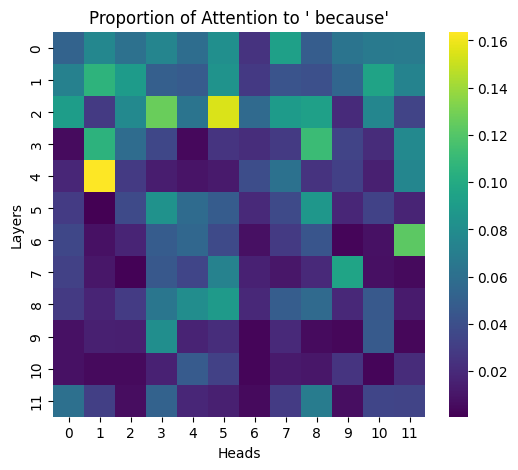

In [26]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Define an array of prompts
prompts = ['Alice went to the park because she wanted to find a treasure.',
           'Alice plays guitar because she enjoys strumming melodies.',
           'Alice went to Paris because Paris is a good place for art.']

causal_delim = " because"
n_layers = gpt2_small.cfg.n_layers
n_heads = gpt2_small.cfg.n_heads

# Will accumulate the proportions layer-by-layer, head-by-head
attn_prop_causal_delim_all_prompts = torch.zeros(n_layers, n_heads)

for prompt in prompts:
    tokens = gpt2_small.to_tokens(prompt)
    logits, cache = gpt2_small.run_with_cache(tokens, remove_batch_dim=True)

    str_tokens = gpt2_small.to_str_tokens(prompt)
    if causal_delim not in str_tokens:
        continue

    delim_idx = str_tokens.index(causal_delim)
    for layer in range(n_layers):
        # attn shape: [n_heads, seq_len, seq_len]
        attn = cache["pattern", layer]
        # Sum over all query positions for the delimiter token
        delim_sum = attn[:, :, delim_idx].sum(dim=1)
        # Total attention in each head (sum over all query & key positions)
        total_sum = attn.sum(dim=(1, 2))
        # Proportion of attention going to the delimiter
        proportion = delim_sum / total_sum
        attn_prop_causal_delim_all_prompts[layer] += proportion

# Average proportions across all prompts
attn_prop_causal_delim_all_prompts /= len(prompts)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_prop_causal_delim_all_prompts.numpy(), cmap="viridis")
plt.title(f"Proportion of Attention to '{causal_delim}'")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.show()

